# Quadratic RF Spoiling bSSFP #

In [1]:
import numpy as np
import math
import random
import matplotlib.pyplot as plt
from scipy.fft import fft
from scipy.optimize import curve_fit

import pandas as pd
import openpyxl

# Functions
## Bloch simulation

In [2]:
#RF pulse excitation matrix
def RF_pulse(alpha, phi):
    #The RF pulse tip the spin "alpha" degree from z axis
    #and a phase shift of "phi" degree clockwise from x axis
    
    #convert in to radians 
    a = math.radians(alpha)
    p = math.radians(phi)
    #each term of the matrix
    r11 = math.cos(a)*math.sin(p)**2 + math.cos(p)**2
    r12 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r13 = - math.sin(a)*math.sin(p)
    r21 = (1 - math.cos(a))*math.cos(p)*math.sin(p)
    r22 = math.cos(a)*math.cos(p)**2 + math.sin(p)**2
    r23 = math.sin(a)*math.cos(p)
    r31 = math.sin(a)*math.sin(p)
    r32 = - math.sin(a)*math.cos(p)
    r33 = math.cos(a)
    R = np.asarray([[r11,r12,r13],[r21,r22,r23],[r31,r32,r33]], dtype = float)
    
    return R

#T1 recovery, T2 decay terms effect for time t
def Relaxation(t, T1, T2):
    e2 = np.exp(-t/T2)
    e1 = np.exp(-t/T1)
    E = np.asarray([[e2 , 0, 0],[0, e2, 0],[0, 0, e1]], dtype = float)
    
    return E

#Precession term effect on off-resonance (f_off Hz) spin at time t
def Precession(f_off, t):
    #free-precession angle beta
    b = f_off*t*2*math.pi
    #rad
    #b = math.radians(beta)
    P = np.asarray([[math.cos(b), math.sin(b), 0],[-math.sin(b), math.cos(b), 0],[0, 0, 1]], dtype = float)
    
    return P

#Calculate the phase shift for current TR (quadratic spoiling)
def QuadraticPhase(N, n):
    n = n%N
    phi_quad = 360/N
    phase = phi_quad*n*n/2
 
    #in degree
    return phase



#Fourier Transform & inverse Fourier Transform
def fft(f, axis = (0)):
    x = (axis)
    tmp0 = np.fft.fftshift(f, axes = (x,))
    tmp1 = np.fft.fft(tmp0, axis = x)
    F = np.fft.ifftshift(tmp1, axes = (x,))
    return F / f.shape[x]

def ifft(F, axis = (0)):
    x = (axis)
    tmp0 = np.fft.ifftshift(F, axes = (x,))
    tmp1 = np.fft.ifft(tmp0, axis = x)
    f = np.fft.fftshift(tmp1, axes = (x,))
    return f * F.shape[x]


<p>Parameters T1, T2, TR, TE, tip angle, period, initial magnetisation. <p/>


## basic quadatic RF spoiling bSSFP - data simulation function #
<p>phase $\phi_n =\frac{n^2 \times \phi_{quad}}{2} $ <p/>
<p>No noise added, No field inhomogeneous added<p/>

In [3]:

def basic_quadratic_RFspoiling_bSSFP(T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, dataAcquire, TRnum):
    #store value
    off_resonance_f = np.asarray([], dtype = int)
    M_complex_steady_all = np.asarray(np.zeros((dataAcquire,1)), dtype = float)


    #Find steady state value for different off-resonance 
    #f_off = 200 is next period, so here we only use -200~199
    for f_off in range(-off_res_max,off_res_max,1):
        M_pre = M0 #initial pre pulse magnetisation 

        #store complex transverse magnitude at different TRs
        M_complex_steady = np.asarray([], dtype = float)
        #store all complex transverse magnitude 
        M_complex = np.asarray([], dtype = float)
        phase_shift = 0
        Period_num = 0



        #repeat TRnum times for each off-resonance frequency
        for k in range(1,TRnum):
            #Calculate phase shift (degree) for this TR
            phase_shift = QuadraticPhase(Period, Period_num)
            #Tip
            M_post = RF_pulse(tip_angle,phase_shift) @ M_pre

            #Consider T1 recovery, T2 decay and precession
            #@ time TE 
            P_TE = Precession(f_off,TE) #precession matrix at t = TE
            E_TE = Relaxation(TE, T1, T2) #Relaxation matrix at t = TE

            M_TE = P_TE @ E_TE @ M_post + (np.identity(3) - E_TE) @ M0 #magnetisation at TE
            

            #@ time TR 
            P_TR = Precession(f_off,TR) #precession matrix at t = TR
            E_TR = Relaxation(TR, T1, T2) #Relaxation matrix at t = TR
            M_TR = P_TR @ E_TR @ M_post + (np.identity(3) - E_TR) @ M0 #magnetisation at TR
            M_pre = M_TR

            #store the transverse magnetisation in complex form, Mx+iMy
            M_complex = np.append(M_complex, complex(M_TE[0],M_TE[1]))

            Period_num = Period_num + 1     
        #END
        #take the final steady signal, store the transverse steady state signal for different off-resonance frequency
        for state in range (1,dataAcquire+1):
            M_complex_steady = np.append(M_complex_steady, M_complex[-state])
        off_resonance_f = np.append(off_resonance_f, f_off)
        M_complex_steady = np.reshape(M_complex_steady,(dataAcquire,1))
        M_complex_steady_all = np.append(M_complex_steady_all, M_complex_steady, axis = 1)
        
    #END
    M_complex_steady_all = np.delete(M_complex_steady_all,0,1)
    
    return M_complex_steady_all, off_resonance_f

#return 
#transverse steady state magnitude at different off-resonance frequency (column) and when acquire at different TR (row)
#corresponding off-resonance frequency


## Quadratic RF spoiling bSSFP - data simulation function
## with Noise and Field inhomogeneous

In [31]:
#Simulate Data with different field inhomogeneous effect (different T2*) and random noise 
def quadratic_RFspoiling_bSSFP (T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, TRnum, M_transverse, off_resonance_f, T2p, testnum, AddNoise):
    
    SimulatedData = np.asarray([], dtype = float) #Array with (T2*num, noise num, off-res f num)
    T2Star_GT = np.asarray([], dtype = float) #Store the Ground Truth T2*
    #simulate basic off-resonance profile
    #M_transverse, off_resonance_f = basic_quadratic_RFspoiling_bSSFP(T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, 1, TRnum)
    
    #Add field inhomogeneous 
    for T2_inhom in T2p:
        #Store Ground truth T2*------------------------------------
        T2Star_GT = np.append(T2Star_GT, 1/((1/T2)+(1/T2_inhom)))
        
        #Add inhomogeneous, get the off-resonance profile with inhomogeneous effect added
        M_transverse_inhomo = AddfieldInhomogeneous(M_transverse, TR, TE, T2_inhom, off_resonance_f)
        
        #Add Noise
        for test in range (0, testnum ):
            if (AddNoise == True):
                M_transverse_inhomo_noise = M_transverse_inhomo + np.random.normal(0,0.01,np.shape(M_transverse_inhomo)[-1]) + 1j*np.random.normal(0,0.01,np.shape(M_transverse_inhomo)[-1])
            else:
                M_transverse_inhomo_noise = M_transverse_inhomo
            SimulatedData = np.append(SimulatedData, M_transverse_inhomo_noise)
#         #______________________T2* Fit________TESTING______________________________
#         F_state_magnitude, F_state = Fstate (M_transverse_noise)
        
#         F_state = np.round(F_state).astype(int) #round F-state all to integer 
#         F = np.asarray([], dtype = float)
#         F_Magnitude = np.asarray([], dtype = float)
#         for i in range (0,6):
#             F_index = np.where(F_state == float(-1-2*i))

#             F = np.append(F, i)
#             F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))
            
#         #End

#         ## time = TE+F*TR
#         time = TE*np.ones(np.shape(F))+ F *TR
        
#         def func(t, A, R2Star):
#             return A * np.exp(-R2Star * t)
#         #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
#         popt, pcov = curve_fit(func, time, F_Magnitude)
        
#         plt.figure(1)
#         plt.plot(time, F_Magnitude)
#         T2Star_measured = 1/popt[1]
#         print(T2Star_GT)
#         print(T2Star_measured)
#         #______________________________TESTING______________________________
        
    #Reshape into 3D Array(T2*num, noise num, off-res f num)    
    SimulatedData = SimulatedData.reshape(np.shape(T2p)[0], testnum, np.shape(M_transverse_inhomo_noise)[-1])   
        
    return SimulatedData, T2Star_GT

In [5]:
#Off-resonance profile magnitude --> F-state magnitude 
def Fstate(M_transverse):
    F_Magnitude = np.fft.fftshift(M_transverse)
    F_Magnitude = np.fft.fft(F_Magnitude)/M_transverse.shape[-1]
    F_Magnitude = np.fft.ifftshift(F_Magnitude)
    

    F_state = np.fft.fftfreq(M_transverse.shape[-1], d = 1.0)
    F_state = np.fft.fftshift(F_state)*M_transverse.shape[-1]
    
    return F_Magnitude, F_state


#plot off resonance profile and F-state profile for multiple data acquisition 
#dataAcquire: number of profile
#off_resonance_f (n,) || M_transverse (dataAcquire, n)
def Offres_Fstate_plot(off_resonance_f, M_transverse, dataAcquire, Period, Fmin, Fmax):
    F_Magnitude, F_state = Fstate(M_transverse)
                                            
            
        
#     #Fourier transform of the off-resonance profile --> contribution from each F-state
#     S_F = np.fft.fft(M_transverse)/np.shape(np.squeeze(M_transverse))[0]
#     S_F = np.absolute(S_F)
#     S_F = np.fft.fftshift(S_F)

#     F_state = np.fft.fftfreq(M_transverse.shape[-1], d = 1.0)
#     F_state = np.fft.fftshift(F_state)*M_transverse.shape[-1]
    

    fig, axs  = plt.subplots(dataAcquire,2,figsize=(15, 5))
    if (dataAcquire == 1):
        axs[0].set_title("off-resonance profile")
        axs[1].set_title("Fstate of " + str(Period)+ " period")

        axs[0].plot(off_resonance_f, np.absolute(M_transverse[0,:]))
        axs[0].set_xlabel("off resonance frequency (Hz)")
        axs[0].set_ylabel("$|M_{xy}|$")

        axs[1].bar(F_state, np.absolute(F_Magnitude[0,:]))
        axs[1].set_xlim([Fmin,Fmax])
        axs[1].set_xlabel("F state")
        axs[1].set_ylabel("$F_Magnitude$")
    else:    
        axs[0,0].set_title("off-resonance profile")
        axs[0,1].set_title("Fstate of " + str(Period)+ " period")
        for i in range (0,dataAcquire):
            axs[i,0].plot(off_resonance_f, np.absolute(M_transverse[i,:]))
            axs[i,0].set_xlabel("off resonance frequency (Hz)")
            axs[i,0].set_ylabel("$|M_{xy}|$")



            axs[i,1].bar(F_state, np.absolute(F_Magnitude[i,:]))
            axs[i,1].set_xlim([Fmin,Fmax])
            axs[i,1].set_xlabel("F state")
            axs[i,1].set_ylabel("$F_Magnitude$")
    return fig, axs



<p>Add field inhomogeneous <p\>

In [6]:
#Add field inhomogeneous to model T2* effect (for F_number F-states, F_number = 6 --> 0,1,2...5 F-states
def AddfieldInhomogeneous(M_transverse, TR, TE, T2prime, off_resonance_f):
   
    #F-state
    F_state_magnitude, F_state = Fstate(M_transverse)
    F_state = np.round(F_state).astype(int) #round F-state all to integer 
    F_state_magnitude_inhomo = F_state_magnitude
    
    index = 0
    for i in F_state:
        #remove the empty state caused by taking 2 period off-res profile 
        if ((i%2)!= 0):
            F = np.abs(-i//2) #the right F-state (all cast to positive)
            time = TE+ F *TR
            F_state_magnitude_inhomo[0,index] = F_state_magnitude[0,index] *np.exp(-time/T2prime)
        index = index + 1 
    #End
    
    #inverse fft get the off-res profile again
    M_transverse_inhomo = np.fft.ifftshift(F_state_magnitude_inhomo[0,:])
    M_transverse_inhomo = np.fft.ifft(M_transverse_inhomo)*np.shape(F_state_magnitude[0,:])[-1]
    M_transverse_inhomo = np.fft.fftshift(M_transverse_inhomo)
    
    #___________________________________Figure show the process_______________________________________________
    #fig_addinhomo, ax1 = plt.subplots(2, 2, figsize = (15,10))
    #Figure Off-res
    # ax1[0,0].plot(off_resonance_f, np.abs(M_transverse[0,:]))
    # ax1[0,0].set_ylim([0, 0.2])
    # ax1[0,0].set_xlabel("off-resonance frequency")
    # ax1[0,0].set_title("Original off-resonance profile")
    # #Figure F-state of original off-res profile
    # ax1[0,1].bar(F_state, np.abs(F_state_magnitude[0,:]))
    # ax1[0,1].set_xlim([-100,100])
    # ax1[0,1].set_xlabel("F-state")
    # ax1[0,1].set_title("Original F-state")
    # #Figure F-state after add inhomogeneous
    # ax1[1,1].bar(F_state, np.abs(F_state_magnitude_inhomo[0,:]))
    # ax1[1,1].set_xlim([-100,100])
    # ax1[1,1].set_xlabel("F-state")
    # ax1[1,1].set_title("F-state with inhomogeneous")
    # #Figure Off-res after add inhomogeneous
    # ax1[1,0].plot(off_resonance_f,np.abs(M_transverse_inhomo))
    # ax1[1,0].set_ylim([0, 0.2])
    # ax1[1,0].set_title("Off-resonance profile with inhomogeneous")
    # ax1[1,0].set_xlabel("off-resonance frequency")
    
    # plt.figure(1)
    # plt.plot(off_resonance_f,np.abs(M_transverse[0,:]))
    # plt.plot(off_resonance_f,np.abs(M_transverse_inhomo))
    # plt.title("Off-resonance profile with inhomogeneous")
    # plt.xlabel("off-resonance frequency")
    #plt.savefig("./Figure/noise/6Period_addinhomoProcess.jpg")
    return M_transverse_inhomo


# Simulation Parameters

In [43]:
# the parameters used in this simulation 
#time unit --- second
proton_density = 1.0
T1 = 900e-3
T2 = 44e-3
TR = 7e-3 
TE = TR/2
TRnum = 500
# tip angle alpha 10
tip_angle = 10
#phase cycling
Period = 12
#initial magnetisation 
M0 = np.asarray([[0],[0],[1]],dtype = float)
#off resonance profile range
off_res_max = int(1/TR)
#Rep_num = off_res_max*2/(1/TR)

dataAcquire = 1


#T2* range 13 ms to 53 ms
T2s_min = 13
T2s_max = 53
T2p = np.asarray([], dtype = float)
# T2p = np.append(T2p, 1/((1000/13)-1/T2))
# T2p = np.append(T2p, 1/((1000/53)-1/T2))
for i in range (T2s_min, T2s_max):
    #if ((i != (T2*1000)) and (i != 0)):
    T2p = np.append(T2p, 1/((1000/i)-1/T2))
#number of simulation run
testnumber = 100
AddNoise = True 


# Simulate Data
<p>Bloch simulation<p/>

In [44]:
#Generate bSSFP off-resonance profile using Bloch simulation 
#Defined datdataAcquire = 1 
M_transverse, off_resonance_f = basic_quadratic_RFspoiling_bSSFP(T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, 1, TRnum)
  

Text(0.5, 0.98, 'Profiles with T2 decay \n(field inhomogeneous and noise not considered)')

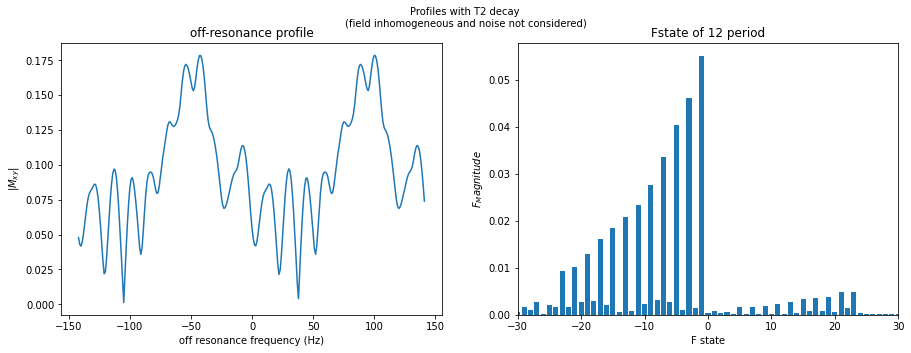

In [45]:
#No Noise, No field inhomogeneous
#Simply Bloch simulation off-resonance profile and F-state profile 
offres_Fstate_Fig, axs = Offres_Fstate_plot(off_resonance_f, M_transverse, dataAcquire, Period, -30, 30)
#axs[1].set(xticklabels=[])
#axs[1].tick_params(bottom=False) 
offres_Fstate_Fig.suptitle("Profiles with T2 decay \n(field inhomogeneous and noise not considered)", fontsize=10)

#offres_Fstate_Fig.savefig("./Figure/noise/12Period_TR_7ms_NoNoise.jpg")

<p>Field inhomogeneous and Noise added<p/>

In [46]:
#Data is an Array contain (T2*num, noise num, off-res f num)
Data, T2Star_GT = quadratic_RFspoiling_bSSFP (T1, T2, off_res_max, TR, TE, tip_angle, Period, M0, TRnum, M_transverse, off_resonance_f, T2p, testnumber, AddNoise)

In [47]:
np.shape(Data)

(40, 3, 284)

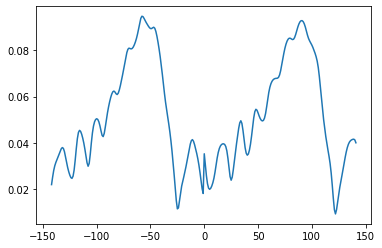

In [48]:
plt.plot(off_resonance_f,np.abs(Data[0,0,:]))
#plt.savefig("./Figure/noise/off_res_profile_6Period_withNoise_"+ str(T2Star_GT[29])+".jpg")

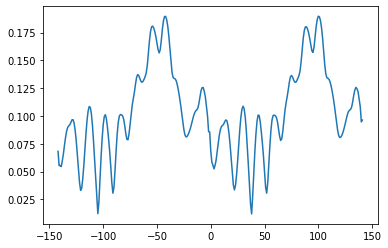

In [49]:
plt.plot(off_resonance_f, np.abs(Data[38,2,:]))
#plt.savefig("./Figure/noise/off_res_profile_6Period_withNoise_"+ str(T2Star_GT[1])+".jpg")

<p>Store Simulated Off-resonance profile if needed <p/>

In [50]:
# #Define arrays for store information ---------------------------
# index = np.asarray([], dtype = str)
# for i in range (1,testnumber+1):
#     index = np.append(index, str(i))
    
# with pd.ExcelWriter('SimulatedOffRes6Period100Noise_NEW.xlsx') as writer:    
# #store data in excel
#     for i in range (0, T2Star_GT.shape[-1]):
#         data = pd.DataFrame(Data[i], index )

#         data.to_excel(writer, sheet_name= str(T2Star_GT[i]))


# T2* value fit using simulated data

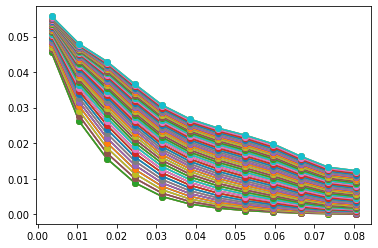

In [51]:
#Performing T2* Fit using the previous simulated data
    
#testnumber*(T2'number) matrix storing T2* ground truth and measured --> used to calculate error later 
#each row store measured T2* value for a ground truth T2*
T2s_m_all = np.asarray([], dtype = float)
#testnumber*2 matrix storing mean error and sd
ErrorMeanSd = np.asarray(np.zeros((1,2)), dtype = float)
Error = np.asarray([], dtype = float)


slicenum = 0 #slice from the dataset, each slice contain several simulated data for one T2*

for GroundTruth in T2Star_GT:
    T2s_m = np.asarray([], dtype = float)
    for test in range (0,testnumber):
        #select each line from dataset 
        M_transverse_measured = Data[slicenum, test, :]
        
        #______________________T2* Fit______________________________________
        F_state_magnitude, F_state = Fstate (M_transverse_measured)
        
        #fit using 6 or less F-states
        F_state = np.round(F_state).astype(int) #round F-state all to integer 
        F = np.asarray([], dtype = float)
        F_Magnitude = np.asarray([], dtype = float)
        if (Period <=6):
            for i in range (0,6):
                F_index = np.where(F_state == float(-1-2*i))

                F = np.append(F, i)
                F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))

            #End
        else:
            for i in range (0,Period):
                F_index = np.where(F_state == float(-1-2*i))

                F = np.append(F, i)
                F_Magnitude = np.append(F_Magnitude, np.abs(F_state_magnitude[F_index]))

            #End

        ## time = TE+F*TR
        time = TE*np.ones(np.shape(F))+ F *TR
        
        def func(t, A, R2Star):
            return A * np.exp(-R2Star * t)
        #fitted coefficient stored in popt:[A R2*] --> T2* = 1/R2*
        popt, pcov = curve_fit(func, time, F_Magnitude)
        
        plt.figure(1)
        plt.plot(time, F_Magnitude, marker = 'o')
        T2Star_measured = 1/popt[1]
        T2s_m = np.append(T2s_m, T2Star_measured)
        #____________________________________________________________
    #For End
    
    #calculate error
    T2s_m_all = np.append(T2s_m_all, T2s_m)
    #Error_test = np.square(T2s_m - GroundTruth)、
    Error_test = T2s_m - GroundTruth
    ErrorMeanSd = np.append(ErrorMeanSd, [(np.mean(Error_test), np.std(Error_test))], axis = 0)
    slicenum = slicenum + 1
#For End

ErrorMeanSd = np.delete(ErrorMeanSd, 0, 0)
T2s_m_all = T2s_m_all.reshape(T2Star_GT.shape[-1], testnumber)

#plt.savefig("./Figure/noise/"+str(Period)+"Period_"+str(TR)+"_TR_T2StarFit.jpg")

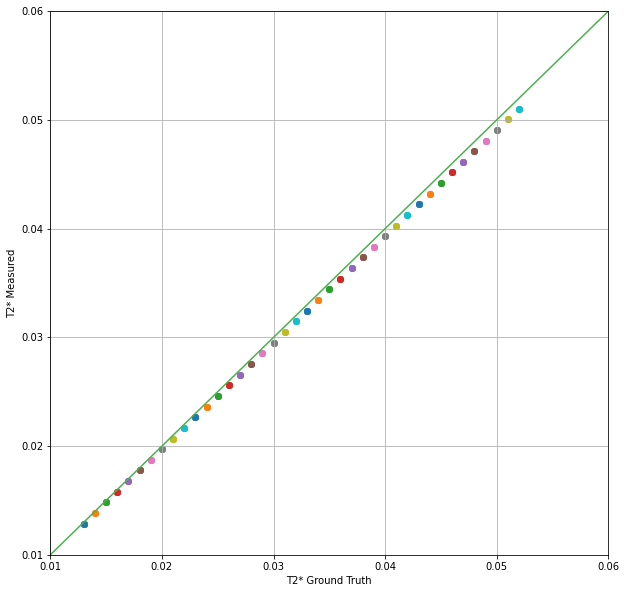

In [52]:
plt.figure(figsize=(10,10))
plt.xlabel("T2* Ground Truth")
plt.ylabel("T2* Measured")
x1 = np.array([-2,5])
y1 = np.array([-2,5])
plt.plot(x1,y1,c = '#4CAF50')
plt.xlim(10e-3, 60e-3)
plt.ylim(10e-3, 60e-3)
plt.grid()

for j in range (0, T2Star_GT.shape[-1]):
    # for i in range (0,testnumber):
    plt.scatter(T2Star_GT[j]*np.ones(testnumber), T2s_m_all[j,:])
    
#plt.savefig("./Figure/noise/"+str(Period)+"Period_"+str(TR)+"_TR_100WithNoise_NEW.jpg") 

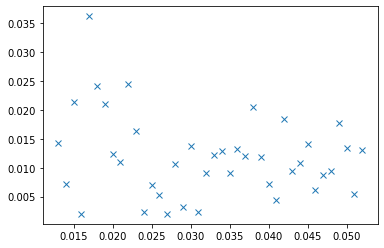

In [42]:
plt.plot(T2Star_GT, ErrorMeanSd[:,1]/T2Star_GT,linestyle='None', marker='x')

In [46]:
#Define arrays for store information ---------------------------
index = np.asarray([], dtype = str)
for i in range (1,T2Star_GT.shape[-1]+1):
    index = np.append(index, str(i))
    
#store data in excel
groundtruth = pd.DataFrame(T2Star_GT, index )
measured = pd.DataFrame(T2s_m_all, index )
error_mean_sd = pd.DataFrame(ErrorMeanSd,
                  index, columns=['Mean Error', 'Standard Deviation'])

with pd.ExcelWriter('./Simulated_Data/SimulatedData'+str(Period)+'Period'+str(testnumber)+'Noise_NEW.xlsx') as writer:
    error_mean_sd.to_excel(writer, sheet_name='Error_mean_sd')
    groundtruth.to_excel(writer, sheet_name='Ground_Truth_T2_Star')
    measured.to_excel(writer, sheet_name='Measured_Truth_T2_Star')
   

# Visualise the RF spoiling phase angle

0.0
15.0
60.0
135.0
240.0
375.0
540.0
735.0
960.0
1215.0
1500.0
1815.0


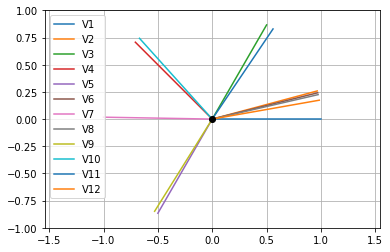

In [117]:
#Visualise the RF quadratic spoiling angle
Period = 12

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
V = np.asarray([[0,0]], dtype = float)
for i in range (0,Period):
    p = QuadraticPhase(Period,i)
    phaseshift_rad = np.radians(p-(p//360))
    print(p)
    #line_1 = plt.Line2D([0,math.cos(phaseshift_rad)], [0,math.sin(phaseshift_rad)], linewidth=1, linestyle = "-", label = i)
    #ax.add_line(line_1)

    V = np.append(V,[[math.cos(phaseshift_rad),math.sin(phaseshift_rad)]], axis =0)
    

V = np.delete(V, 0,0)
# origin = np.array(np.zeros((2,Period))) # origin point
# plt.quiver(*origin, V[:,0], V[:,1], scale=5)
# plt.show()

# ax.set(xlim=[-1,1])
# ax.set(ylim=[-1,1])
#print(V)

rows,cols =V.T.shape

#Get absolute maxes for axis ranges to center origin
#This is optional
maxes = 1.1*np.amax(abs(V), axis = 0)

for i,l in enumerate(range(0,cols)):
    xs = [0,V[i,0]]
    ys = [0,V[i,1]]
    plt.plot(xs,ys)

plt.plot(0,0,'ok') #<-- plot a black point at the origin
plt.axis('equal')  #<-- set the axes to the same scale
plt.xlim([-1,1]) #<-- set the x axis limits
plt.ylim([-1,1]) #<-- set the y axis limits
plt.legend(['V'+str(i+1) for i in range(cols)]) #<-- give a legend
plt.grid(True) #<-- plot grid lines
plt.show()

## 